In [1]:
# Confidence interval and bias comparison via W-estimation in the multi-armed bandits
#
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', palette='colorblind', color_codes=True)


In [2]:
#
# Experiment parameters
#
# Set random seed for reproducibility
seed = 12345
np.random.seed(seed)
# Trial repetitions (number of times experiment is repeated)
R = 4000
# Trial size (total number of arm pulls)
T = 148 * 4
# Number of arms
K = 2
# Noise distribution: 2*beta(alph, alph) - 1
noise_param = 1.0 # uniform distribution
subgauss_param = 1.0
# Parameters of Gaussian distribution prior on each arm
mu0 = 0.3 # prior mean
var0 = 1/(2*noise_param + 1.0) # prior variance set to correct value
# Select reward means for each arm and set variance
reward_means = np.concatenate([np.repeat(.3, K-1), [.31]])
reward_vars = np.repeat(var0, K)
subgauss_arms = subgauss_param*np.ones(K)
# Select probability of choosing current belief in epsilon greedy policy
ECB_epsilon = .1


In [3]:
#
# Evaluation parameters
#
# Confidence levels for confidence regions
confidence_levels = np.arange(0.9, 1.0, step=0.01)
# Standard normal error thresholds for two-sided (univariate) intervals with given confidence level
gaussian_thresholds_ts = -stats.norm.ppf((1.0-confidence_levels)/2.0)
gaussian_thresholds_os = -stats.norm.ppf(1.0-confidence_levels)
print gaussian_thresholds_ts
print gaussian_thresholds_os

[ 1.64485363  1.69539771  1.75068607  1.81191067  1.88079361  1.95996398
  2.05374891  2.17009038  2.32634787  2.5758293 ]
[ 1.28155157  1.34075503  1.40507156  1.47579103  1.55477359  1.64485363
  1.75068607  1.88079361  2.05374891  2.32634787]


In [5]:
#
# Define arm selection policies
#
policies = {}
# Epsilon-greedy: select current belief (arm with highest posterior reward 
# probability) w.p. 1-epsilon and arm uniformly at random otherwise
def ECB(mu_post, var_post, epsilon=ECB_epsilon):
    # Determine whether to select current belief by flipping biased coin
    use_cb = np.random.binomial(1, 1.0-epsilon)
    if use_cb:
        # Select arm with highest posterior reward probability
        arm = np.argmax(mu_post)
    else:
        # Select arm uniformly at random
        arm = np.random.choice(xrange(K))
    return arm
policies['ECB'] = ECB

# Fixed randomized design: each arm selected independently and uniformly
def FR(mu_post, var_post):
    return ECB(mu_post, var_post, epsilon=1.0)
policies['FR'] = FR
# Thompson sampling: select arm k with probability proportional to P(arm k has highest reward | data)^c
# where c = 1 and P(arm k has highest reward | data) is the posterior probability that arm k has
# the highest reward
def TS(mu_post, var_post):
    # Draw a sample from each arm's posterior
    samples = np.random.normal(mu_post, np.sqrt(var_post))
    # Select an arm with the largest sample
    arm = np.argmax(samples)
    return arm
policies['TS'] = TS
def lilUCB(mu_post, var_post):
    #define lilUCB params, see Jamieson et al 2013
    # use 1/variance as number of times the arm is tried.
    # at time t, choose arm k that maximizes:
    # muhat_k(t) + (1+beta)*(1+sqrt(eps))*sqrt{2(1+eps)/T_k}*sqrt{log(1/delta) + log(log((1+eps)*T_k))}
    # where muhat_k (t) is sample mean of k^th arm at time t and T_k = T_k(t) is the number of times arm k is tried
    # up toa time t
    epsilonUCB = 0.01
    betaUCB = 0.5
    aUCB = 1+ 2/betaUCB
    deltaUCB = 0.01
    
    lilFactorUCB = np.log(1/deltaUCB) + np.log(np.log((1+epsilonUCB)/var_post))
    scoresUCB = mu_post + (1+betaUCB)*(1+np.sqrt(epsilonUCB))*np.sqrt((2+2*epsilonUCB)*lilFactorUCB*var_post)
    arm = np.argmax(scoresUCB)
    return arm
policies['UCB'] = lilUCB

In [6]:
#
# Gather data: Generate arm pulls and rewards using different policies
#
tic = time.time()
arms = []
rewards = []
for r in xrange(R):
    arms.append(pd.DataFrame(index=range(0,T)))
    rewards.append(pd.DataFrame(index=range(0,T)))
    
    # Keep track of posterior beta parameters for each arm
    mu_post = np.repeat(mu0, K)
    var_post = np.repeat(var0, K)
    for policy in policies.keys():
        # Ensure arms column has integer type by initializing with integer value
        arms[r][policy] = 0
        for t in range(T):
            if t < K:
                # Ensure each arm selected at least once
                arm = t
            else:
                # Select an arm according to policy
                arm = policies[policy](mu_post, var_post)
            # Collect reward from selected arm
            reward = 2*np.random.beta(noise_param, noise_param) - 1.0 + reward_means[arm]
            # Update Gaussian posterior
            new_var = 1.0/(1.0/var_post[arm] + 1.0/reward_vars[arm])
            mu_post[arm] = (mu_post[arm]/var_post[arm] + reward/reward_vars[arm])*new_var
            var_post[arm] = new_var
            # Store results
            arms[r].set_value(t, policy, arm)
            rewards[r].set_value(t, policy, reward)
    
print "{}s elapsed".format(time.time()-tic)

401.451577187s elapsed


In [7]:

# Inspect arm selections
print arms[0][0:min(10,T)]

   UCB  FR  ECB  TS
0    0   0    0   0
1    1   1    1   1
2    0   0    0   1
3    1   0    1   1
4    0   0    1   1
5    0   1    1   1
6    1   1    1   1
7    1   1    1   1
8    1   1    1   1
9    1   0    1   0


In [8]:
# Display some summary statistics for the collected data
pct_arm_counts={}
for policy in arms[0].keys():
    print policy
    pct_arm_counts[policy] = np.percentile([arms[r][policy].groupby(arms[r][policy]).size().values \
                                            for r in xrange(R)],15, axis=0)
pct_arm_counts    

UCB
FR
ECB
TS


{'ECB': array([ 28.,  32.]),
 'FR': array([ 283.,  284.]),
 'TS': array([  48.  ,  145.85]),
 'UCB': array([ 207.,  236.])}

In [9]:
# 
# Form estimates: For each method, compute reward probability estimates and 
# single-parameter error thresholds for confidence intervals
#
tic = time.time()
estimates = []
thresholds_ts = []
thresholds_os = []
for r in xrange(R):
    estimates.append({})
    thresholds_ts.append({})
    thresholds_os.append({})
    for policy in arms[r].columns:
        # Create list of estimates and confidence regions for this policy
        estimates[r][policy] = {}
        thresholds_ts[r][policy] = {}
        thresholds_os[r][policy] = {}
        #
        # OLS with asymptotic Gaussian confidence
        #
        # Compute estimates of arm reward probabilities
        estimates[r][policy]['OLS_gsn'] = rewards[r][policy].groupby(arms[r][policy]).mean().values
        # Asymptotic marginal variances diag((X^tX)^{-1})
        arm_counts = arms[r][policy].groupby(arms[r][policy]).size().values
        variances = reward_vars / arm_counts
        # Compute asymptotic Gaussian single-parameter confidence thresholds
        thresholds_ts[r][policy]['OLS_gsn'] = np.outer(np.sqrt(variances), gaussian_thresholds_ts)
        thresholds_os[r][policy]['OLS_gsn'] = np.outer(np.sqrt(variances), gaussian_thresholds_os)
        #
        # OLS with concentration inequality confidence
        #   
        # Compute estimates of arm reward probabilities
        estimates[r][policy]['OLS_conc'] = np.copy(estimates[r][policy]['OLS_gsn'])
        # Compute single-parameter confidence intervals using concentration inequalities
        # of https://arxiv.org/pdf/1102.2670.pdf Sec. 4
        # threshold_ts = subgaussian_parameter * sqrt((1+N_k)/N_k^2 * (1+2*log(sqrt(1+N_k)/delta)))
        thresholds_ts[r][policy]['OLS_conc'] = subgauss_arms * np.concatenate([ 
            np.sqrt(((1.0+arm_counts)/arm_counts**2) * (1+2*np.log(np.sqrt(1.0+arm_counts)/(1-c))))[:,None]
            for c in confidence_levels], axis=1)
        thresholds_os[r][policy]['OLS_conc'] = np.copy(thresholds_ts[r][policy]['OLS_conc'])
        # 
        # W estimate with asymptotic Gaussian confidence
        # Y: using lambda_min = min_median_arm_count/log(T) as W_Lambdas
        # avg_arm_counts = pct_arm_counts[policy]/log(T)
        W_lambdas = np.ones(T)*min(pct_arm_counts[policy])/np.log(T)
        # Latest parameter estimate vector
        beta = np.copy(estimates[r][policy]['OLS_gsn']) ###
        # Latest w_t vector
        w = np.zeros((K))
        # Latest matrix W_tX_t = w_1 x_1^T + ... + w_t x_t^T
        WX = np.zeros((K,K))
        # Latest vector of marginal variances reward_vars * (w_1**2 + ... + w_t**2)
        variances = 0.0
        for t in range(T):
            # x_t = e_{arm}
            arm = arms[r][policy][t]
            # y_t = reward
            reward = rewards[r][policy][t]
            # Update w_t = (1/(norm{x_t}^2+lambda_t)) (x_t - W_{t-1} X_{t-1} x_t)
            np.copyto(w, -WX[:,arm])
            w[arm] += 1
            w /= (1.0+W_lambdas[t])
            # Update beta_t = beta_{t-1} + w_t (y_t - <beta_OLS, x_t>)
            beta += w * (reward - estimates[r][policy]['OLS_gsn'][arm]) ###
            # Update W_tX_t = W_{t-1}X_{t-1} + w_t x_t^T 
            WX[:,arm] += w
            # Update marginal variances
            variances += reward_vars * w**2
        estimates[r][policy]['W'] = beta
        # Compute asymptotic Gaussian single-parameter confidence thresholds and coverage
        thresholds_ts[r][policy]['W'] = np.outer(np.sqrt(variances), gaussian_thresholds_ts)
        thresholds_os[r][policy]['W'] = np.outer(np.sqrt(variances), gaussian_thresholds_os)
print "{}s elapsed".format(time.time()-tic)


900.15949893s elapsed


In [11]:
# Display some summary statistics concerning the model estimates
if False:
    for policy in ["ECB","TS"]:#arms[0].keys():
        for method in estimates[0][policy].keys():
            print "{} {}".format(policy, method)
            print "average estimate: {}".format(np.mean([estimates[r][policy][method] for r in xrange(R)], axis=0))
            print "average threshold:\n{}".format(np.mean([thresholds_os[r][policy][method] for r in xrange(R)], axis=0))
        print ""

In [12]:
#
# Evaluate estimates: For each policy and method, compute confidence interval 
# coverage probability and width
#
tic = time.time()
coverage = [] # Check if truth in [estimate +/- thresh]
upper_coverage = [] # Check if truth >= estimate - thresh
lower_coverage = [] # Check if truth <= estimate + thresh
upper_diff_coverage = [] # Check if beta_2 - beta_1 >= estimate - thresh
lower_diff_coverage = [] # Check if beta_2 - beta_1 <= estimate + thresh
for r in xrange(R):
    coverage.append({})
    upper_coverage.append({})
    lower_coverage.append({})
    upper_diff_coverage.append({})
    lower_diff_coverage.append({})
    for policy in estimates[r].keys():
        # Interval coverage for each method
        coverage[r][policy] = {}
        upper_coverage[r][policy] = {}
        lower_coverage[r][policy] = {}
        upper_diff_coverage[r][policy] = {}
        lower_diff_coverage[r][policy] = {}
        for method in estimates[r][policy].keys():
            # Compute error of estimate
            error = estimates[r][policy][method] - reward_means
            # Compute coverage of interval
            coverage[r][policy][method] = np.absolute(error)[:,None] <= thresholds_ts[r][policy][method]
            upper_coverage[r][policy][method] = error[:,None] <= thresholds_os[r][policy][method]
            lower_coverage[r][policy][method] = error[:,None] >= -thresholds_os[r][policy][method]
            upper_diff_coverage[r][policy][method] = error[1]-error[0] <= np.sqrt((thresholds_os[r][policy][method]**2).sum(axis=0))
            lower_diff_coverage[r][policy][method] = error[1]-error[0] >= -np.sqrt((thresholds_os[r][policy][method]**2).sum(axis=0))
print "{}s elapsed".format(time.time()-tic)

2.79937911034s elapsed


In [13]:
# set up some plotting configuration

path = 'figs/'
policies = ['UCB', 'TS', 'ECB']
methods = ["OLS_gsn","OLS_conc", "W"]
markers = {}
markers['OLS_gsn'] = 'v'
markers['OLS_conc'] = '^'
markers['W'] = 'o'

colors = {}
colors['OLS_gsn'] = sns.color_palette()[0]
colors['OLS_conc'] = sns.color_palette()[1]
colors['W'] = sns.color_palette()[2]
colors['Nominal'] = sns.color_palette()[5]
colors['OLS_emp'] = sns.color_palette()[3]

legend_font_size = 14
label_font_size = 14
title_font_size = 16


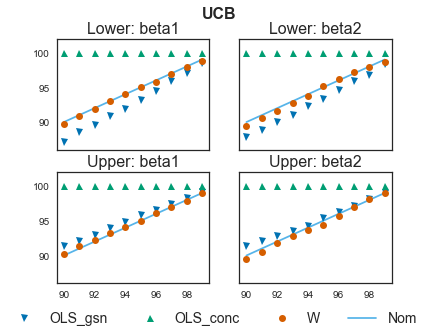

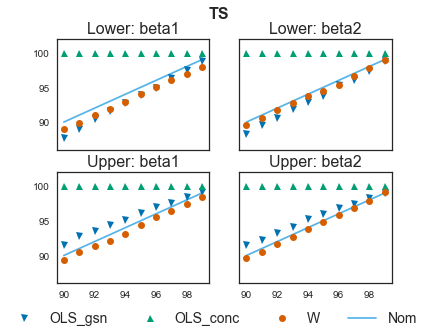

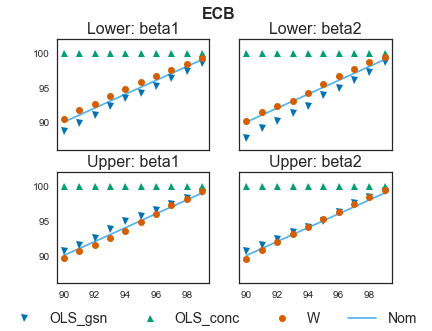

In [112]:
#
# Display coverage results
#

# For each policy and method, display coverage as a function of confidence level

methods = ['OLS_gsn', 'OLS_conc', 'W']
for policy in policies:
    fig, axes = plt.subplots(2, K, sharey=True, sharex=True)
    for k in range(K):
        for m in range(len(methods)):
            method = methods[m]
            axes[0, k].errorbar(100*confidence_levels,
                               100*np.mean([lower_coverage[r][policy][method][k,:] for r in xrange(R)],axis=0),
                               label = method, 
                               marker=markers[method],
                               color=colors[method], 
                               linestyle='')
            #print np.mean([lower_coverage[r][policy]['W'][k,:] for r in xrange(R)],axis=0)
        axes[0,k].plot(100*confidence_levels, 100*confidence_levels, color=colors['Nominal'], label='Nominal')
        #axes[0, k].set(adjustable='box-forced', aspect='equal')
        axes[0, k].set_title("Lower: beta"+str(k+1), fontsize = title_font_size)
        axes[0, k].set_ylim([86, 102])
        for method in methods:

            axes[1, k].errorbar(100*confidence_levels,
                               100*np.mean([upper_coverage[r][policy][method][k,:] for r in xrange(R)],axis=0),
                               label = method,
                               marker = markers[method],
                               color=colors[method], 
                               linestyle = '')
        axes[1,k].plot(100*confidence_levels, 100*confidence_levels, color=colors['Nominal'], label='Nominal')
        #axes[1,k].set(adjustable='box-forced', aspect='equal')
        axes[1,k].set_title("Upper: beta"+str(k+1), fontsize = title_font_size)
    # fig.tight_layout()

    plt.figlegend( axes[1,0].get_lines(), methods+['Nom'], loc = (0.01, 0), ncol=5, labelspacing=0. , fontsize = legend_font_size)
    fig.suptitle(policy, fontsize = title_font_size, fontweight='bold')
    fig.set_size_inches(6,4.5 )
    fig.savefig(path+'mab_{}_coverage'.format(policy))
    plt.show()

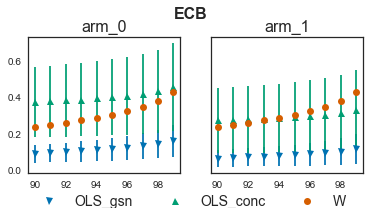

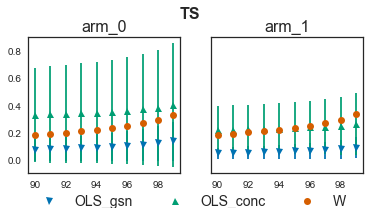

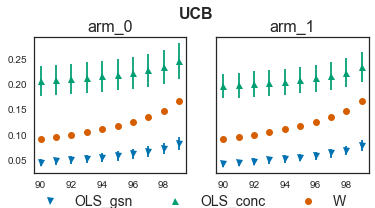

In [136]:
#
# Display width results
#
# For each policy and method, display mean width as a function of confidence level
policies = ["ECB", "TS", 'UCB']
methods = ['OLS_gsn', 'OLS_conc', 'W']
for policy in policies:
    fig, axes = plt.subplots(1, K, sharey=True)
    for k in range(K):
        
        for method in methods:
            axes[k].errorbar(100*confidence_levels, \
                    np.mean([thresholds_os[r][policy][method][k,:] for r in xrange(R)],axis=0), \
                    np.std([thresholds_os[r][policy][method][k,:] for r in xrange(R)], axis=0),\
                    label = method,
                    marker = markers[method],
                    color=colors[method],
                    linestyle='')
            
        # axes[k].legend(loc='')
        axes[k].set_title('arm_{}'.format(k), fontsize = title_font_size)
        # axes[k].set_yscale('log', nonposy='clip')
    fig.suptitle(policy, fontsize = title_font_size, x=0.5, y=1.05, fontweight='bold')
    plt.figlegend( axes[0].get_lines(), methods, 
                  loc=(0.08,-0.03) ,
                  ncol = 3,
                  # loc= (0.75, 0.3),
                  labelspacing=0. , 
                  fontsize = legend_font_size)
    fig.set_size_inches(6, 2.5, forward=True)
    fig.savefig(path+'mab_{}_width'.format(policy), bbox_inches='tight', pad_inches=0.1)
    plt.show()



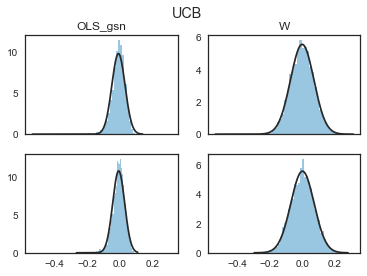

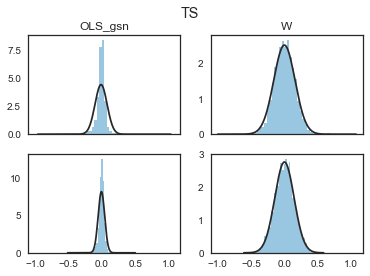

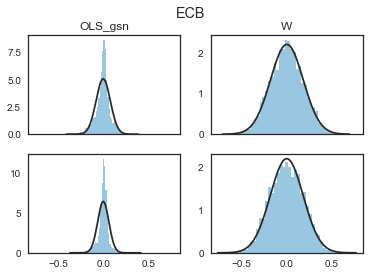

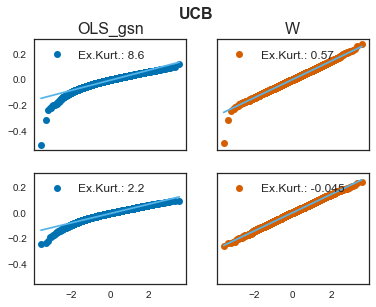

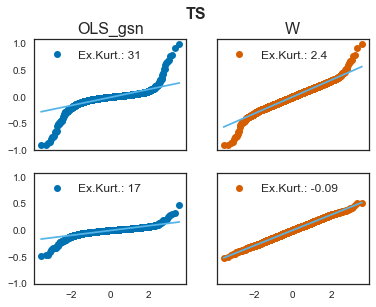

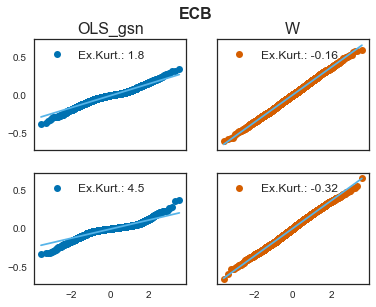

In [122]:
#
# Visualize distribution of parameter estimation error
#
policies = ["UCB", 'TS', 'ECB']
methods = ["OLS_gsn", "W"]
# Plot histograms of errors
for policy in policies:
    fig, axes = plt.subplots(nrows=len(methods), ncols=K, sharex=True)
    for m in range(len(methods)):
        method = methods[m]
        for k in range(K):
            sns.distplot([estimates[r][policy][method][k] - reward_means[k] for r in xrange(R)], 
                        kde=False,
                        fit = stats.norm,
                        color = colors[method]
                        hist_kws=dict(alpha=1),
                        ax=axes[k, m])
            #axes[k,m].hist([estimates[r][policy][method][k] - reward_means[k] for r in xrange(R)],
                          #bins=50, facecolor = 'g')
            if k == 0:
                axes[k,m].set_title(method)
    fig.suptitle(policy)
#    fig.savefig(path+'mab_{}_histogram'.format(policy))
    plt.show()

# Plot qqplots of errors
import scipy.stats as stats
for policy in policies:
    fig, axes = plt.subplots(nrows=len(methods), ncols=K, sharex=True, sharey=True)
    for m in range(len(methods)):
        method = methods[m]
        for k in range(K):
            errors = [estimates[r][policy][method][k] - reward_means[k] for r in xrange(R)]
            # sm.graphics.qqplot(errors, line='s', ax=axes[k, m])
            orderedstats, fitparams = stats.probplot(errors, 
                           dist="norm", plot=None)
            
            axes[k, m].plot(orderedstats[0], orderedstats[1], marker='o', linestyle='', color=colors[method])
            axes[k, m].plot(orderedstats[0], fitparams[0]*orderedstats[0] + fitparams[1], color = colors['Nominal'])
            #axes[k, m].plot(orderedstats[0], fitparams[0]*orderedstats[0] + fitparams[1]) #replot to get orange color
            
            if k == 0:
                axes[k,m].set_title(method, fontsize=title_font_size)
                axes[k,m].set_xlabel("")
            else:
                axes[k,m].set_title("")
            # Display empirical kurtosis to 3 significant figures
            axes[k,m].legend(loc='upper left', 
                             labels=['Ex.Kurt.: {0:.2g}'.format(
                                stats.kurtosis(errors, fisher=True))], fontsize=12)
    fig.suptitle(policy, fontsize=title_font_size, fontweight='bold')
    fig.set_size_inches(6, 4.5)
    # fig.savefig(path+'mab_{}_qq'.format(policy))
    plt.show()
